In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import toolplot
import tooltime

from ctc import evm
from ctc.protocols import fei_utils
from ctc.protocols import chainlink_utils

%matplotlib inline

In [2]:
toolplot.setup_plot_formatting()

In [3]:
# specify blocks

# start_block = 14000000
start_block = 13500000
end_block = await evm.async_get_latest_block_number()
n_samples = 1000

blocks = np.linspace(start_block, end_block, n_samples).astype(int)
print('start_block:', start_block)
print('end_block:', end_block)
print('total blocks:', end_block - start_block + 1)
print('blocks sampled:', len(blocks))

start_block: 13500000
end_block: 14849121
total blocks: 1349122
blocks sampled: 1000


# Gather Data

In [4]:
# gather pcv stats

pcv_stats = await fei_utils.async_get_pcv_stats_by_block(
    blocks=blocks,
    provider={'chunk_size': 1},
)

pcv_stats

,pcv,user_fei,protocol_equity,valid
13500000,1.054603e+09,3.398038e+08,7.147995e+08,True
13501350,1.047020e+09,3.456615e+08,7.013588e+08,True
13502700,1.043327e+09,3.504772e+08,6.928497e+08,True
13504051,1.046199e+09,3.333628e+08,7.128367e+08,True
13505401,1.051151e+09,3.070959e+08,7.440550e+08,True
...,...,...,...,...
14843719,4.126098e+08,2.380034e+08,1.746064e+08,True
14845069,4.081048e+08,2.352146e+08,1.728902e+08,True
14846420,4.025104e+08,2.354173e+08,1.670932e+08,True
14847770,3.881634e+08,2.378229e+08,1.503405e+08,True


In [5]:
# gather prices

eth_usd = await chainlink_utils.async_get_eth_price_by_block(blocks=blocks)

eth_usd

13500000    4022.523217
13501350    3964.348732
13502700    3928.739448
13504051    4013.220000
13505401    4151.960000
               ...     
14843719    1970.380000
14845069    1959.405824
14846420    1922.976833
14847770    1814.950000
14849121    1883.761303
Length: 1000, dtype: float64

In [6]:
# compile data

data = pcv_stats.copy()
data['cr'] = data['pcv'] / data['user_fei']
data['eth_usd'] = eth_usd

In [7]:
# save data

name = 'cadlabs_exploratory_data__' + tooltime.create_timestamp_label() + '.csv'
data.to_csv(name)
print('saved to: ' + name)

saved to: cadlabs_exploratory_data__20220526_165643Z.csv


# Visualize Data

## metrics vs time

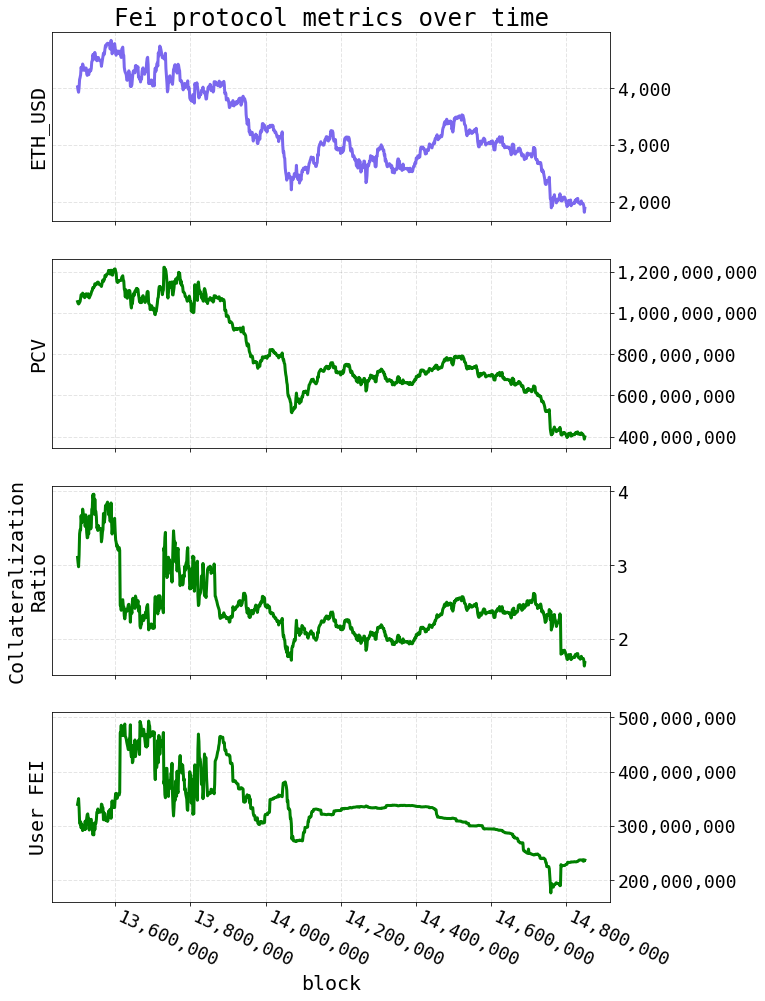

In [8]:
plots = {
    'subplot_height': 4,
    'common': {
        'x': blocks,
        'name_position': 'ylabel',
        'tickgrid': True,
        'xtick_format': {'xticks_kwargs': {'color': 'white'}},
        'ytick_format': {},
    },
    'plots': {
        'ETH_USD': {
            'name': 'ETH_USD',
            'y': data['eth_usd'],
            'y_kwargs': {'color': 'mediumslateblue'},
            'title': 'Fei protocol metrics over time',
        },
        'PCV': {
            'name': 'PCV',
            'y': data['pcv'],
            'y_kwargs': {'color': 'green'},
        },
        'CR': {
            'name': 'Collateralization\nRatio',
            'y': data['cr'],
            'y_kwargs': {'color': 'green'},
        },
        'User FEI': {
            'name': 'User FEI',
            'y': data['user_fei'],
            'y_kwargs': {'color': 'green'},
            'xtick_format': {},
            'xlabel': 'block',
        },
    },
}

toolplot.plot_subplots(plots)

## metrics vs eth price

you can see that there is a strong linear correlation between PCV and ETH price

the other relationships are more complex and noisy

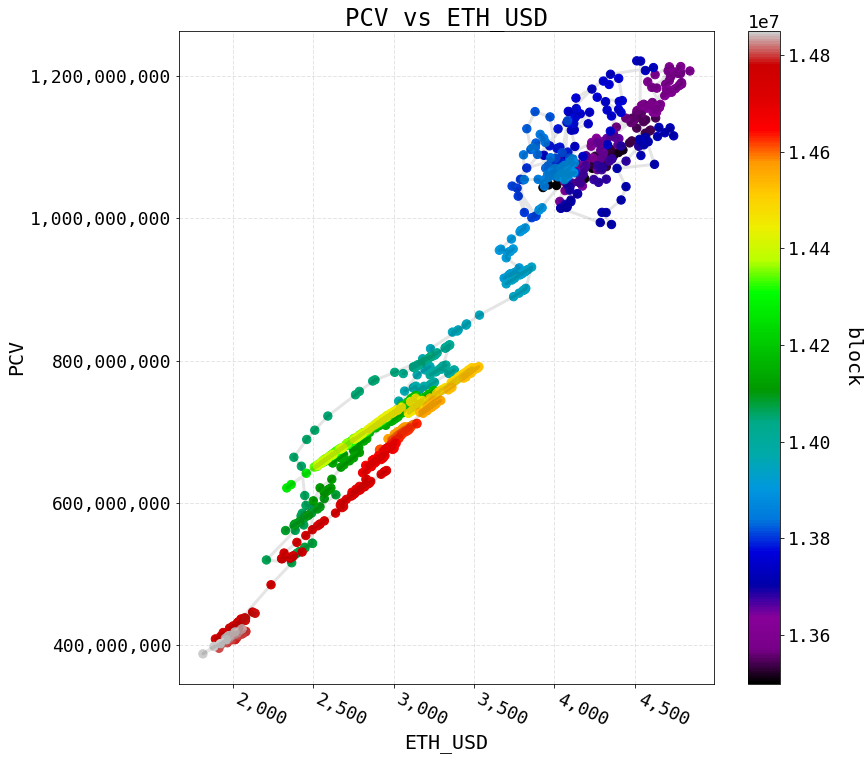

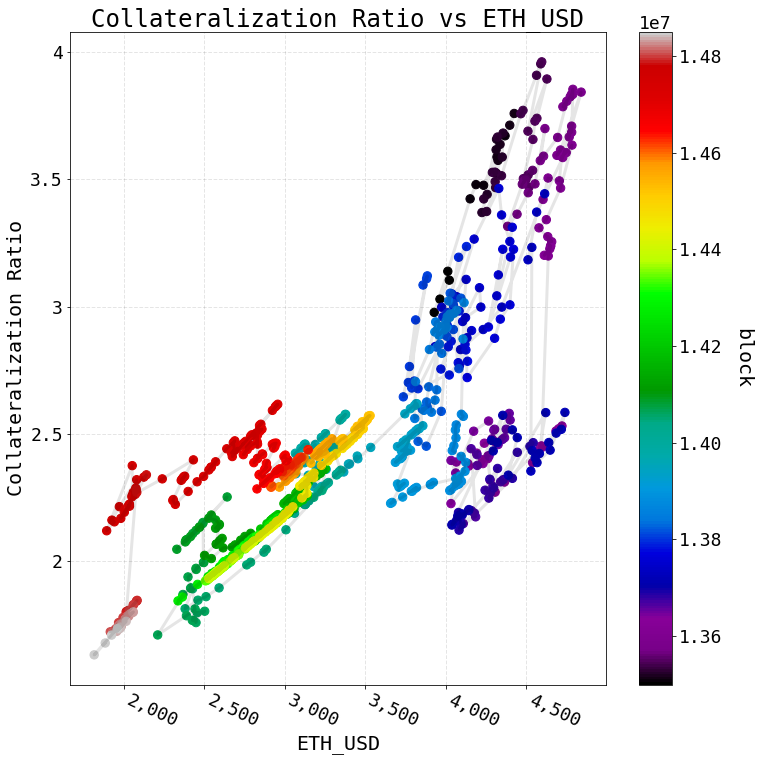

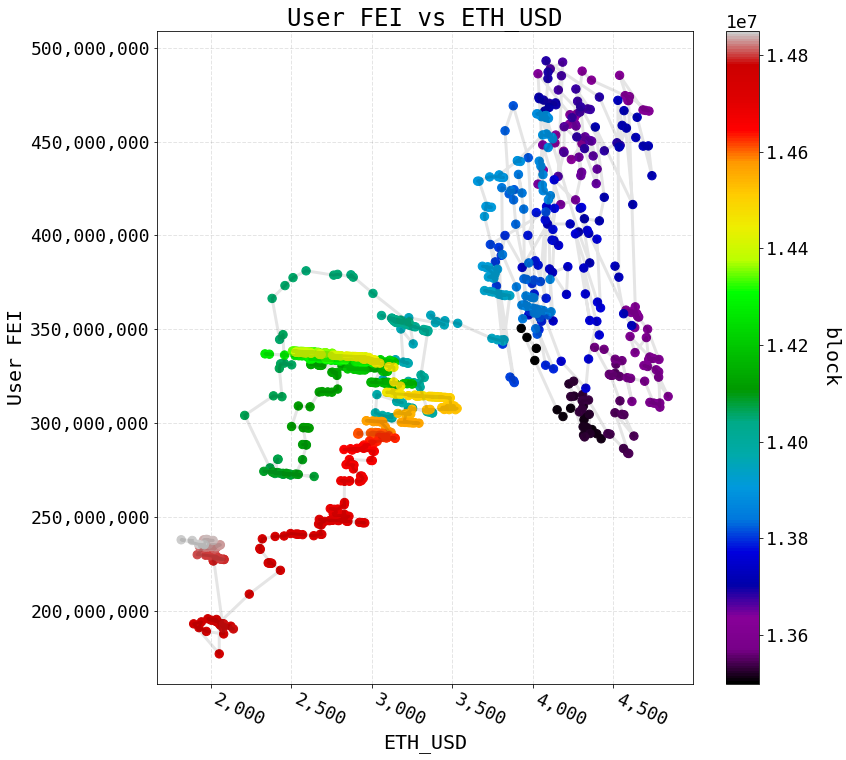

In [9]:
for key, name in [
    ['pcv', 'PCV'],
    ['cr', 'Collateralization Ratio'],
    ['user_fei', 'User FEI'],
]:
    plt.scatter(eth_usd, data[key], c=blocks, cmap='nipy_spectral', s=70)
    plt.plot(eth_usd, data[key], color='black', alpha=0.1)
    cbar = plt.colorbar()
    cbar.set_label('block', labelpad=30, rotation=270)
    plt.xlabel('ETH_USD')
    plt.ylabel(name)
    plt.title(name + ' vs ' + str('ETH_USD'))
    toolplot.format_xticks()
    toolplot.format_yticks()
    toolplot.add_tick_grid()
    plt.show()